In [399]:
import numpy as np
import matplotlib.pyplot as plt
import fluids as fl
import sympy as sp
from pint import _DEFAULT_REGISTRY as u

In [400]:
class propFeed():
    def __init__(self):
        self.componentName = None
        self.componentNumber = None #For sorting later

    #Establishing sorting criteria
    def __lt__(self, other):
        return self.componentNumber < other.componentNumber

In [401]:
class liquids(propFeed):
    def __init__(self, propellantName, liquidDensity, liquidViscosity, liquidMassFlow):
        self.propellantName = propellantName
        self.liquidDensity = liquidDensity
        self.liquidViscosity = liquidViscosity
        self.liquidMassFlow = liquidMassFlow

    def updateViscosity(self, newViscosity):
        self.liquidViscosity = newViscosity

In [402]:
class liquidValves(liquids):
    def __init__(self, ID, Cv, componentNumber, componentName, **args):
        self.Cv = Cv
        self.ID = ID
        self.area = (np.pi*((ID/2)**2))
        
        #Runs the superclass constructor with the additional arguments (which are meant to be the unpacked attributes of a liquid profile)
        super().__init__(**args)
        self.componentNumber = componentNumber
        self.componentName = componentName

        self.velocity = self.liquidMassFlow / (self.liquidDensity * self.area.to("meter**2"))
        self.reynolds = fl.units.Reynolds(V = self.velocity, D = self.ID, rho = self.liquidDensity, mu = self.liquidViscosity)
        self.K = fl.units.Cv_to_K(self.Cv, self.ID)
        self.pressureDrop = (fl.units.dP_from_K(K = self.K, rho = self.liquidDensity, V = self.velocity)).to("psi")

    #Function to update calculated properties if given liquid properties change
    def updateArgs(self):
        self.velocity = self.liquidMassFlow / (self.liquidDensity * self.area.to("meter**2"))
        self.reynolds = fl.units.Reynolds(V = self.velocity, D = self.ID, rho = self.liquidDensity, mu = self.liquidViscosity)
        self.K = fl.units.Cv_to_K(self.Cv, self.ID)
        self.pressureDrop = (fl.units.dP_from_K(K = self.K, rho = self.liquidDensity, V = self.velocity)).to("psi")

    #def KFactorFunc(self):
        #K, Cv, ID = sp.symbols("K, Cv, ID", real=True)
        #eqn = sp.Eq(K, (1.6 * 10**9)*((ID**4)/(Cv/1.56)**2))
        #solutionList = sp.solve(eqn, K)
        #solution = solutionList[0].subs([(Cv, self.Cv), (ID, self.Cv)])
        #print(solution)

In [403]:
class liquidBends(liquids):
    def __init__(self, ID, bendAngle, bendRadius, roughness, componentNumber, componentName, **args):
        self.ID = ID
        self.angle = bendAngle
        self.bendRadius = bendRadius
        self.roughness = roughness
        self.area = np.pi*((ID/2)**2)
        
        #Runs the superclass constructor with the additional arguments (which are meant to be the unpacked attributes of a liquid profile)
        super().__init__(**args)
        self.componentNumber = componentNumber
        self.componentName = componentName

        self.velocity = self.liquidMassFlow / (self.liquidDensity * self.area.to("meter**2"))
        self.reynolds = fl.units.Reynolds(V = self.velocity, D = self.ID, rho = self.liquidDensity, mu = self.liquidViscosity)
        self.frictionFactor = fl.units.friction_factor(Re = self.reynolds, eD = (self.roughness/self.ID), Darcy = True)
        self.K = fl.units.bend_rounded(Di = self.ID, angle = self.angle, rc = self.bendRadius, fd = self.frictionFactor, Re = self.reynolds, roughness = self.roughness, method = 'Rennels')
        self.pressureDrop = (fl.units.dP_from_K(K = self.K, rho = self.liquidDensity, V = self.velocity)).to("psi")

    #Function to update calculated properties if given liquid properties change
    def updateArgs(self):
        self.velocity = self.liquidMassFlow / (self.liquidDensity * self.area.to("meter**2"))
        self.reynolds = fl.units.Reynolds(V = self.velocity, D = self.ID, rho = self.liquidDensity, mu = self.liquidViscosity)
        self.frictionFactor = fl.units.friction_factor(Re = self.reynolds, eD = (self.roughness/self.ID), Darcy = True)
        self.K = fl.units.bend_rounded(Di = self.ID, angle = self.angle, rc = self.bendRadius, fd = self.frictionFactor, Re = self.reynolds, roughness = self.roughness, method = 'Rennels')
        self.pressureDrop = (fl.units.dP_from_K(K = self.K, rho = self.liquidDensity, V = self.velocity)).to("psi")


In [404]:
class liquidStraights(liquids):
    def __init__(self, ID, length, roughness, componentNumber, componentName, **args):
        self.ID = ID
        self.length = length
        self.roughness = roughness
        self.area = np.pi*((ID/2)**2)
        
        #Runs the superclass constructor with the additional arguments (which are meant to be the unpacked attributes of a liquid profile)
        super().__init__(**args)
        self.componentNumber = componentNumber
        self.componentName = componentName

        self.velocity = self.liquidMassFlow / (self.liquidDensity * self.area.to("meter**2"))
        self.reynolds = fl.units.Reynolds(V = self.velocity, D = self.ID, rho = self.liquidDensity, mu = self.liquidViscosity)
        self.frictionFactor = fl.units.friction_factor(Re = self.reynolds, eD = (self.roughness/self.ID), Darcy = True)
        self.K = fl.units.K_from_f(fd = self.frictionFactor, L = self.length, D = self.ID)
        self.pressureDrop = (fl.units.dP_from_K(K = self.K, rho = self.liquidDensity, V = self.velocity)).to("psi")

    #Function to update calculated properties if given liquid properties change
    def updateArgs(self):
        self.velocity = self.liquidMassFlow / (self.liquidDensity * self.area.to("meter**2"))
        self.reynolds = fl.units.Reynolds(V = self.velocity, D = self.ID, rho = self.liquidDensity, mu = self.liquidViscosity)
        self.frictionFactor = fl.units.friction_factor(Re = self.reynolds, eD = (self.roughness/self.ID), Darcy = True)
        self.K = fl.units.K_from_f(fd = self.frictionFactor, L = self.length, D = self.ID)
        self.pressureDrop = (fl.units.dP_from_K(K = self.K, rho = self.liquidDensity, V = self.velocity)).to("psi")


In [405]:
#Create a liquid object "profile"
LOX = liquids(propellantName = "LOX", liquidDensity = 1200*(u.kilogram/u.meter**3), liquidViscosity = 274.41*(u.micropascal*u.second), liquidMassFlow = 0.9*(u.kilogram/u.second))
Kerosene = liquids(propellantName = "Kerosene", liquidDensity = 0.81*(u.gram/u.centimeter**3), liquidViscosity = 0.00164*(u.pascal*u.second), liquidMassFlow = 0.91*(u.kilogram/u.second))

#Create objects of various classes
#Notice that the first argument is always an unpacked dict of the component's corresponding liquid profile, followed by arguments unique to that class of components
LOXStraight1 = liquidStraights(**LOX.__dict__, ID = 0.402*(u.inch), length = 6*(u.inch), roughness = 10*(u.micron), componentNumber = 1, componentName = "LOXStraight1")
LOXMain = liquidValves(**LOX.__dict__, ID = 0.59*(u.inch), Cv = 9.7*(u.gallon/u.minute), componentNumber = 2, componentName = "LOXValve1")
LOXStraight2 = liquidStraights(**LOX.__dict__, ID = 0.402*(u.inch), length = 12*(u.inch), roughness = 10*(u.micron), componentNumber = 3, componentName = "LOXStraight2")
LOXBend1 = liquidBends(**LOX.__dict__, ID = 0.402*(u.inch), bendAngle = 90*(u.degree), bendRadius = 1*(u.inch), roughness = 10*(u.micron), componentNumber = 4, componentName = "LOXBend1")
LOXStraight3 = liquidStraights(**LOX.__dict__, ID = 0.402*(u.inch), length = 24*(u.inch), roughness = 10*(u.micron), componentNumber = 5, componentName = "LOXStraight3")
LOXBend2 = liquidBends(**LOX.__dict__, ID = 0.402*(u.inch), bendAngle = 90*(u.degree), bendRadius = 1*(u.inch), roughness = 10*(u.micron), componentNumber = 6, componentName = "LOXBend2")
LOXStraight4 = liquidStraights(**LOX.__dict__, ID = 0.402*(u.inch), length = 24*(u.inch), roughness = 10*(u.micron), componentNumber = 7, componentName = "LOXStraight4")
LOXBend3 = liquidBends(**LOX.__dict__, ID = 0.402*(u.inch), bendAngle = 90*(u.degree), bendRadius = 1*(u.inch), roughness = 10*(u.micron), componentNumber = 8, componentName = "LOXBend3")
LOXStraight5 = liquidStraights(**LOX.__dict__, ID = 0.402*(u.inch), length = 2*(u.inch), roughness = 10*(u.micron), componentNumber = 9, componentName = "LOXStraight5")


In [406]:
components = [LOXStraight1, LOXMain, LOXStraight2, LOXBend1, LOXStraight3, LOXBend2, LOXStraight4, LOXBend3, LOXStraight5]
sortedComponents = sorted(components) #sorts components
totalPressureLossTracker = []
viscosityRange = np.arange(0.0001, 0.0011, 0.0001) * (u.pascal * u.second)

for viscosity in viscosityRange:
    #Create initial pressure and array to keep track of pressure
    initialPressure = 150.639013*(u.psi)
    pressureTracker = []
    pressureTracker.append(initialPressure)
    LOX.liquidViscosity = viscosity

    #Iterates through every component
    for component in sortedComponents:
        print(f"Name: {component.componentName}, Component Number: {component.componentNumber}")
        print(f"Inlet Pressure: {initialPressure}")

        #Updates viscosity, then updates all other properties based on viscosity 
        component.updateViscosity(viscosity)
        component.updateArgs()

        #Update Pressure
        initialPressure = initialPressure - component.pressureDrop
        pressureTracker.append(initialPressure)

        print(f"Outlet Pressure: {initialPressure}")
        print(f"Pressure Drop: {component.pressureDrop}")
        print(f"Reynolds: {component.reynolds}\n")
        print(f"Viscosity: {component.liquidViscosity}\n")

    print(pressureTracker)
    print(f"Total Pressure Drop: {pressureTracker[0] - initialPressure}\n")
    totalPressureLossTracker.append(pressureTracker[0].magnitude - initialPressure.magnitude)

Name: LOXStraight1, Component Number: 1
Inlet Pressure: 150.639013 pound_force_per_square_inch
Outlet Pressure: 148.47993322827998 pound_force_per_square_inch
Pressure Drop: 2.159079771720033 pound_force_per_square_inch
Reynolds: 1122258.3835366927 dimensionless

Viscosity: 0.0001 pascal * second

Name: LOXValve1, Component Number: 2
Inlet Pressure: 148.47993322827998 pound_force_per_square_inch
Outlet Pressure: 146.6763268258749 pound_force_per_square_inch
Pressure Drop: 1.803606402405091 pound_force_per_square_inch
Reynolds: 764657.407087713 dimensionless

Viscosity: 0.0001 pascal * second

Name: LOXStraight2, Component Number: 3
Inlet Pressure: 146.6763268258749 pound_force_per_square_inch
Outlet Pressure: 142.35816728243483 pound_force_per_square_inch
Pressure Drop: 4.318159543440066 pound_force_per_square_inch
Reynolds: 1122258.3835366927 dimensionless

Viscosity: 0.0001 pascal * second

Name: LOXBend1, Component Number: 4
Inlet Pressure: 142.35816728243483 pound_force_per_square_

[0.0001 0.0002 0.00030000000000000003 0.0004 0.0005 0.0006000000000000001 0.0007000000000000001 0.0008 0.0009000000000000001 0.001] pascal * second
[30.970532159716512, 31.341419895775047, 31.695816424229932, 32.03549886901959, 32.36195503251456, 32.67644464587654, 32.980044977791806, 33.273685409048355, 33.558174060365474, 33.83421859099646]


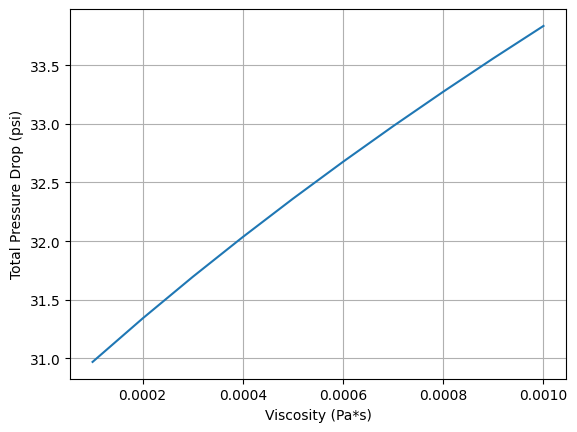

In [407]:
print(viscosityRange)
print(totalPressureLossTracker)

fig, ax = plt.subplots()
varPlot = ax.plot(viscosityRange, totalPressureLossTracker)
ax.grid(visible = True)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel("Viscosity (Pa*s)")
ax.set_ylabel("Total Pressure Drop (psi)")
#plt.axvline(x = 0.19, color = 'r', linestyle = '-')
#plt.xticks(np.arange(0, 5+0.5, 0.25), rotation = 'vertical')
plt.show()